In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
import levenberg_marquardt
from matplotlib.pyplot import figure
import heston
from importlib import reload
reload(heston)
from heston import calibrate_heston, get_tick
import datetime
from scipy import stats as sps
from typing import Union
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [71]:
%%time
raw = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")

CPU times: user 16 s, sys: 3.35 s, total: 19.4 s
Wall time: 25 s


In [72]:
def process_data(data):
    # only options
    df = data.copy()
    df = df[(df["instrument"].str.endswith("C")) | (df["instrument"].str.endswith("P"))].sort_values("dt")
    df["type"] = np.where(df["instrument"].str.endswith("C"), "call", "put")
    
    perpetuals = data[data["instrument"].str.endswith("PERPETUAL")][["dt", "price"]].copy()
    perpetuals = perpetuals.rename(columns = {"price": "underlying_price"}).sort_values("dt")
    
    def get_strike(x):
        return int(x.split("-")[2])
    
    def get_expiration(x):
        return x.split("-")[1]
    

    df["strike_price"] = df["instrument"].apply(get_strike)
    df["expiration"] = df["instrument"].apply(get_expiration)
    
    def unix_time_millis(dt):
        epoch = datetime.datetime.utcfromtimestamp(0)
        return int((dt - epoch).total_seconds() * 1000_000)
    
    def get_normal_date(s):
        """Function to convert date to find years to maturity"""
        monthToNum = {
            "JAN": 1,
            "FEB": 2,
            "MAR": 3,
            "APR": 4,
            "MAY": 5,
            "JUN": 6,
            "JUL": 7,
            "AUG": 8,
            "SEP": 9,
            "OCT": 10,
            "NOV": 11,
            "DEC": 12,
        }

        full_date = s.split("-")[1]
        try:
            day = int(full_date[:2])
            month = monthToNum[full_date[2:5]]
        except:
            day = int(full_date[:1])
            month = monthToNum[full_date[1:4]]
        
        year = int("20" + full_date[-2:])
        exp_date = datetime.datetime(year, month, day)
        return unix_time_millis(exp_date)
    
    df["dt"] = pd.to_datetime(df["dt"])
    perpetuals["dt"] = pd.to_datetime(perpetuals["dt"])
    
    df = pd.merge_asof(df, perpetuals, on="dt",
                       tolerance=pd.Timedelta('7 minutes'),
                       direction='nearest',)
    
    df["timestamp"] = df["dt"].apply(unix_time_millis)
    df["expiration"] = df["instrument"].apply(get_normal_date)
    df = df.rename(columns = {"price": "mark_price"})
    
    
    return df


In [73]:
%%time
start = process_data(raw)


In [96]:
df = start.copy()
df = df[(df["timestamp"]>=1672000000000000) & (df["timestamp"]<=1672800000000000)]
df

,dt,mark_price,instrument,type,strike_price,expiration,underlying_price,timestamp
2501457,2022-12-25 20:30:00.654,0.0010,ETH-30DEC22-300-P,put,300,1672358400000000,1205.95,1672000200654000
2501458,2022-12-25 20:30:00.654,0.0005,ETH-30DEC22-40000-C,call,40000,1672358400000000,1205.95,1672000200654000
2501459,2022-12-25 20:30:00.654,0.0005,ETH-30DEC22-500-P,put,500,1672358400000000,1205.95,1672000200654000
2501460,2022-12-25 20:30:00.654,0.0005,ETH-30DEC22-600-P,put,600,1672358400000000,1205.95,1672000200654000
2501461,2022-12-25 20:30:00.654,0.0005,ETH-30DEC22-700-P,put,700,1672358400000000,1205.95,1672000200654000
...,...,...,...,...,...,...,...,...
3144467,2023-01-04 02:39:55.787,0.0055,ETH-6JAN23-1250-C,call,1250,1672963200000000,1229.50,1672799995787000
3144468,2023-01-04 02:39:56.239,0.0290,ETH-6JAN23-1200-C,call,1200,1672963200000000,1229.45,1672799996239000
3144469,2023-01-04 02:39:56.244,0.0595,ETH-6JAN23-1300-P,put,1300,1672963200000000,1229.45,1672799996244000
3144470,2023-01-04 02:39:56.303,0.0055,ETH-6JAN23-1250-C,call,1250,1672963200000000,1229.45,1672799996303000


In [49]:
df_s = pd.read_csv(f"../datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
df_s = df_s.drop(columns = ["exchange", "open_interest", 
                    "last_price", "bid_price", "bid_amount", "bid_iv",
                           "ask_price", "ask_amount", "ask_iv", "underlying_index",
                           "delta", "gamma", "vega", "theta" ,"rho"])
currency = "ETH"
ind = [symbol.startswith(currency) for symbol in df_s.symbol]
df_s = df_s[ind].reset_index(drop=True)
# df = df[df["expiration"] == 1680249600000000]
# after expiration
# df = df[df["timestamp"] > 1669881600000000]
# df = df[df["timestamp"]<=1669928620213347.0]

In [140]:
df = df_s.copy()
df = df[df["expiration"].isin([1680249600000000, 1688112000000000, 
                               1672387200000000, 1674806400000000, 1669968000000000, 
                               1695974400000000, 1677225600000000])]

In [142]:
# calibrate base
number_of_dots = 30
timestamps_hm = []
names = ["kappa", "nu_bar", "sigma", "rho", "nu0"]
params_all = []
params_nu0 = []
errors_all = []
errors_nu0 = []

a = np.float64(2.4)  # kappa    a                 |  mean reversion rate | kappa (Article) | kappa (Roland's)
b = np.float64(1.3)  # v_infinity                |  long term variance | nu_bar           | alpha_bar 
c = np.float64(4.5)  # sigma                    |  volatility of volatility | sigma      | mu
rho = np.float64(-0.4)  # rho                    |  correlation between spot and vol |rho | rho
v0 = np.float64(0.65) # init variance            | initial variance | nu_0                | alpha_0
start_params = np.array([a, b, c, rho, v0])
print("Optimize first params with random start once")
calibrated_params_all, first_error_all = calibrate_heston(df = df, 
                                                          start_params = start_params, calibration_type = "all")
calibrated_params_nu0, first_error_nu0 = calibrate_heston(df = df, 
                                                          start_params = start_params, calibration_type = "nu0")
print("all first calibrated", calibrated_params_all)
print("nu0 first calibrated", calibrated_params_nu0)

# Get ticks with similar distnce from available data
timestamps = np.linspace(df.timestamp.min(), df.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    try:
        # zero params for each point are params from last step
        calibrated_params_all, error_all = calibrate_heston(df = df, start_params = calibrated_params_all, 
                                                            timestamp = timestamp, calibration_type = "all")
        print("All calibrated:", calibrated_params_all)
        # save all calib_params
        params_all.append(calibrated_params_all)
        errors_all.append(error_all)
        
        
        calibrated_params_nu0, error_nu0 = calibrate_heston(df = df, start_params = calibrated_params_nu0, 
                                                            timestamp = timestamp, calibration_type = "nu0")
        print("nu0 calibrated:", calibrated_params_nu0)
        # save nu0 calib params
        params_nu0.append(calibrated_params_nu0)
        errors_nu0.append(error_nu0)
        
        
        print("    ")
        # save timestame that could calibrate
        timestamps_hm.append(timestamp)
            
    except ValueError:
        # if could not calibrate, start next calibration with prev params
        print(f"Could not calibrate LM on {timestamp}")
        calibrated_params_all = start_params
        calibrated_params_nu0 = start_params
#         calibrated_params_all = params_all[-1]
#         try:
#             calibrated_params_nu0 = params_nu0[-1]
#         except:
#             calibrated_params_nu0 = params_all[-1]
        
    except IndexError:
        print(f"Could not calibrate nu0 {timestamp}")
        calibrated_params_all = start_params
        calibrated_params_nu0 = start_params
#         calibrated_params_all = params_all[-1]
#         try:
#             calibrated_params_nu0 = params_nu0[-1]
#         except:
#             calibrated_params_nu0 = params_all[-1]
        
    except ZeroDivisionError:
        print(f"Zero dev jacobian on {timestamp}")
        calibrated_params_all = start_params
        calibrated_params_nu0 = start_params
        print(f"Zero dev jacobian on {timestamp}")
#         calibrated_params_all = params_all[-1]
#         try:
#             calibrated_params_nu0 = params_nu0[-1]
#         except:
#             calibrated_params_nu0 = params_all[-1]

    

timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000000.0) for x in timestamps_hm]
params_all = np.array(params_all).T
params_nu0 = np.array(params_nu0).T

Optimize first params with random start once
all first calibrated [ 0.47660896  3.          3.46229923 -0.39337679  0.6736133 ]
nu0 first calibrated [ 4.41994823  1.05049069  4.77283341 -0.37165763  0.44343238]


  0%|          | 0/30 [00:00<?, ?it/s]

All calibrated: [ 5.00000000e+00  1.00000000e-04  4.64763256e+00 -9.08837639e-01
  6.61823204e-01]
Could not calibrate nu0 1669852800013000.0
All calibrated: [ 2.56748502  1.23731421  4.63966496 -0.36822237  0.67888508]
nu0 calibrated: [ 4.98922944  1.03741994  5.         -0.35788937  0.4716229 ]
    
All calibrated: [ 2.3999911   1.26314076  4.50003808 -0.36710214  0.67562073]
nu0 calibrated: [ 5.          1.04754597  5.         -0.36085972  0.45181037]
    
All calibrated: [ 2.38838078  1.25703312  4.44882241 -0.36402087  0.67203914]
nu0 calibrated: [ 5.          1.05074239  5.         -0.35943343  0.44222846]
    
All calibrated: [ 2.44157381  1.26941444  4.57873474 -0.36931484  0.67243529]
nu0 calibrated: [ 5.          1.04954404  5.         -0.36126166  0.44979535]
    
All calibrated: [ 2.46577905  1.25802268  4.58428676 -0.3683095   0.67768332]


KeyboardInterrupt: 

In [ ]:
# single_instr = df[df["instrument"] == df.sample(1).instrument.iloc[0]]
# plt.plot(single_instr["dt"], single_instr["mark_price"])
# plt.plot(df["dt"], df["underlying_price"])

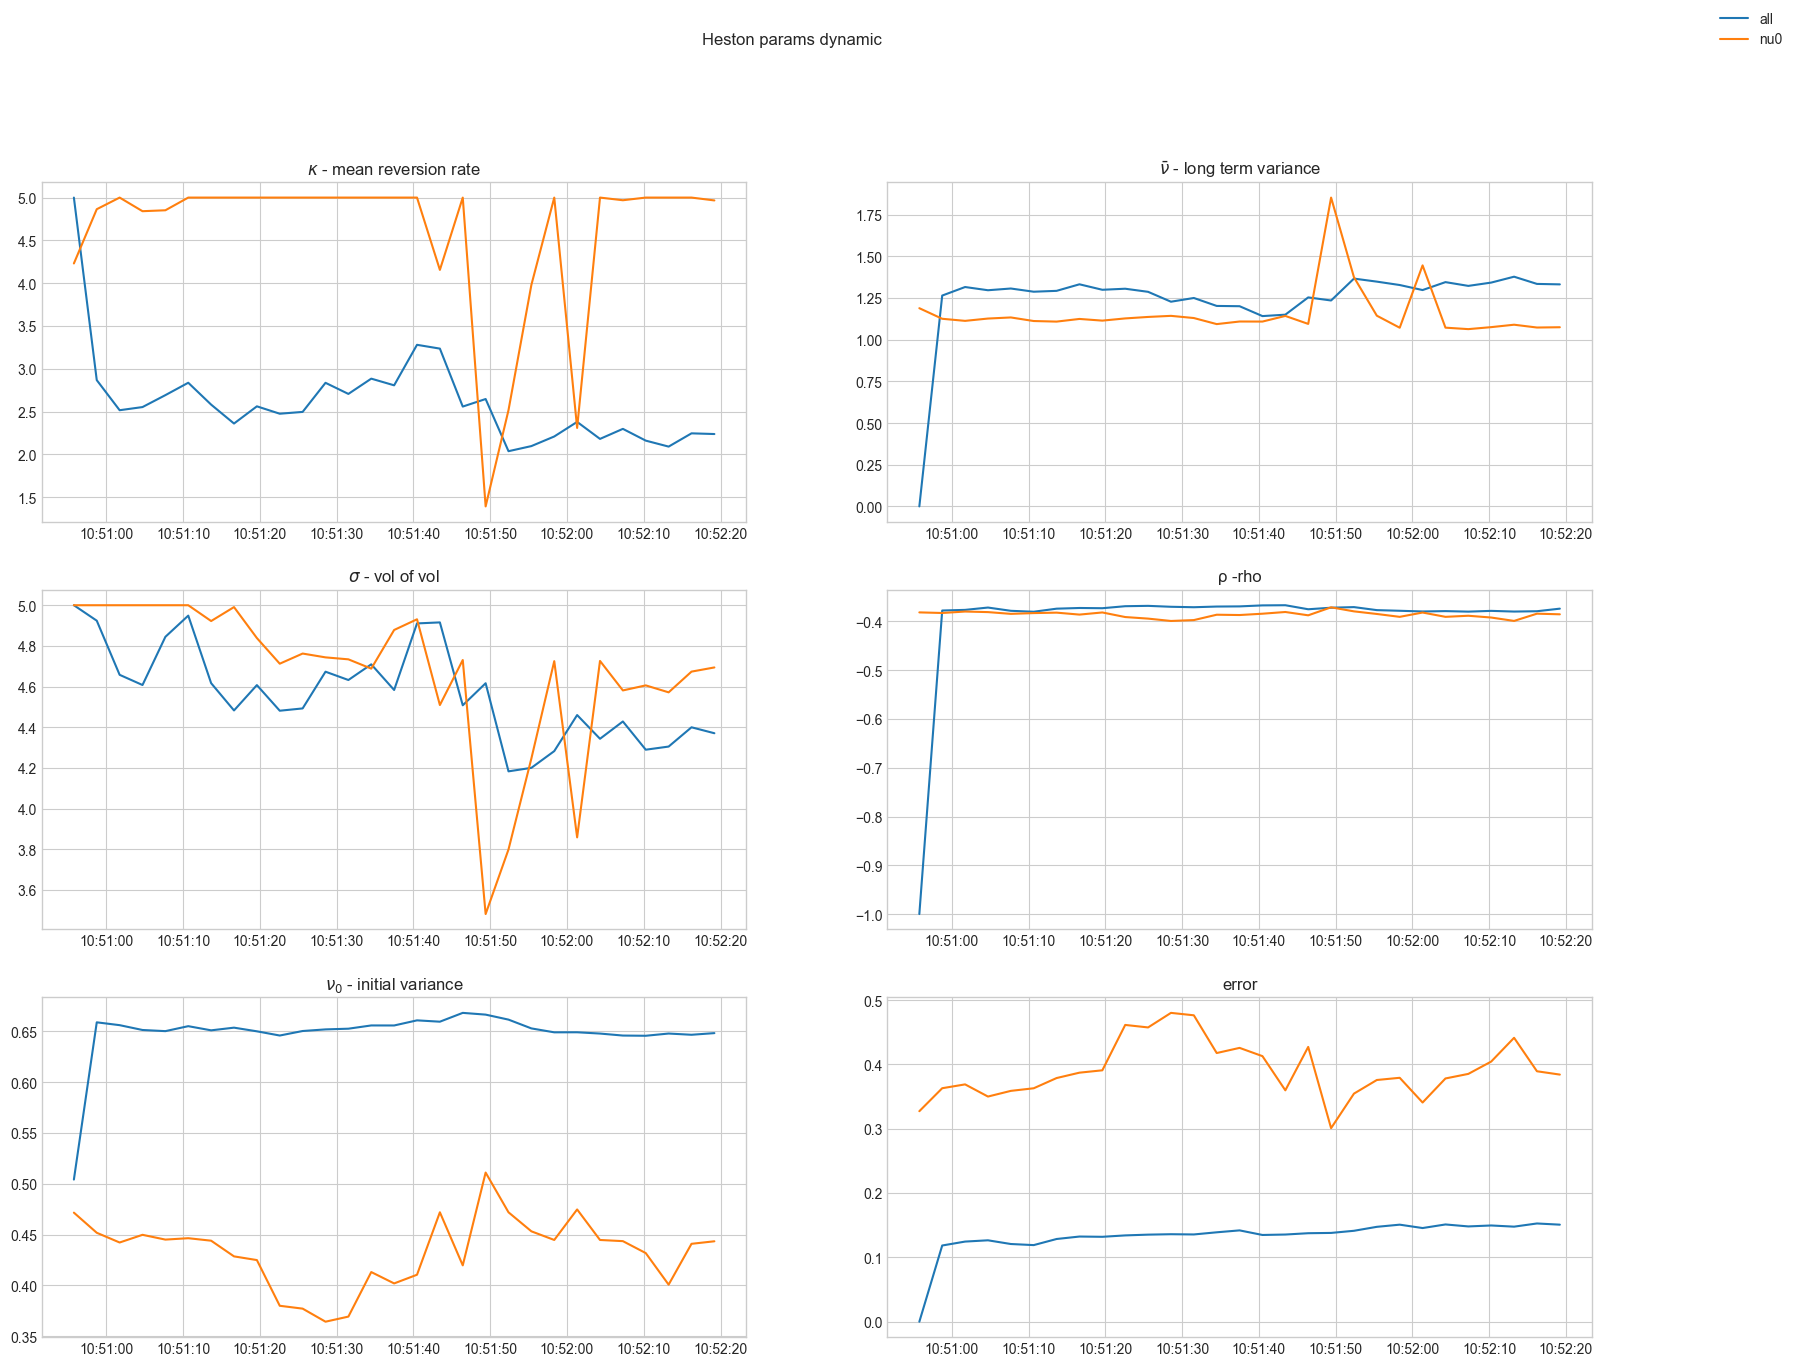

In [135]:
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

axs[0, 0].plot(timestamps_hm, params_all[0][:-1])
axs[0, 0].plot(timestamps_hm, params_nu0[0])
axs[0, 0].set_title(r"$\kappa$ - mean reversion rate")

axs[0, 1].plot(timestamps_hm, params_all[1][:-1])
axs[0, 1].plot(timestamps_hm, params_nu0[1])
axs[0, 1].set_title(r"$\bar{\nu}$ - long term variance")

axs[1, 0].plot(timestamps_hm, params_all[2][:-1], label = "all")
axs[1, 0].plot(timestamps_hm, params_nu0[2], label = "nu0")
axs[1, 0].set_title(r"$\sigma$ - vol of vol")

axs[1, 1].plot(timestamps_hm, params_all[3][:-1])
axs[1, 1].plot(timestamps_hm, params_nu0[3])
axs[1, 1].set_title("ρ -rho")

axs[2, 0].plot(timestamps_hm, params_all[4][:-1])
axs[2, 0].plot(timestamps_hm, params_nu0[4])
axs[2, 0].set_title(r"$\nu_0$ - initial variance")

axs[2, 1].plot(timestamps_hm, errors_all[:-1])
axs[2, 1].plot(timestamps_hm, errors_nu0)
axs[2, 1].set_title("error")



# for i in range(3):
#     for j in range(2):
#         for exp in expirarions:
#             axs[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#             axs[i, j].axvline(x=exp, color = "black", linestyle  = "--")
#             if i == j == 0:
#                 axs[i, j].axvline(x=exp, color = "black", linestyle  = "--", label = exp)
#                 pass


plt.figlegend() 
fig.suptitle("Heston params dynamic")

plt.show()